# Pool Image Classification

The goal of this notebook is to classify from satellite images whether or not a home has a pool. The creation of this notebook relied heavily on a [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) about building neural networks with a small amount of data. To start, let's import packages:

In [1]:
import os # for navigating directories
import numpy as np
from skimage import io # used to load images as numpy arrays
from sklearn.model_selection import train_test_split # split a data set into training and testing
from scipy.misc import imresize, imsave # resize images and save as pngs
import matplotlib.pyplot as plt

from keras.models import Model # basic class for specifying and training a neural network
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten # all the various neural network layers
from keras.utils import np_utils # utilities for one-hot encoding of ground truth value
from keras.optimizers import RMSprop # optimization algorithm to use to search for optimal weights
from keras import regularizers # used to regularize the weights

Using TensorFlow backend.


Next load the data as numpy arrays of the desired size. Of the image sizes I tried, I found 30 x 30 pixels to work best. Given the small amount of data, we want to minimize the number of parameters we need to estimate. Therefore, the smaller we can have the photo (and still be able to distinguish the pool), the better. In order to be sure we aren't setting the resolution too low, the first few images in each class are displayed.

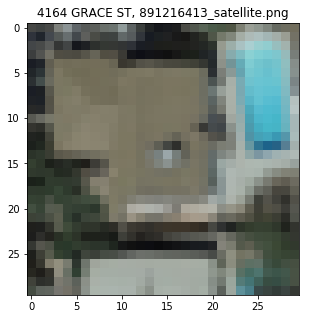

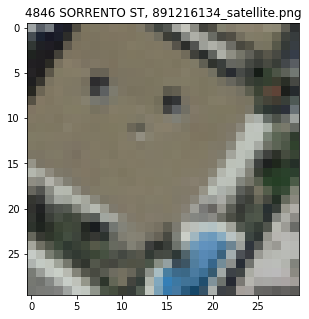

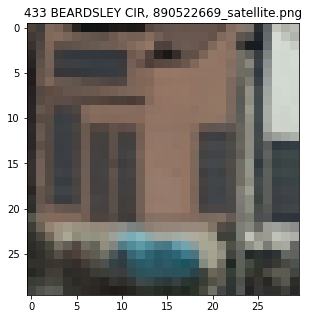

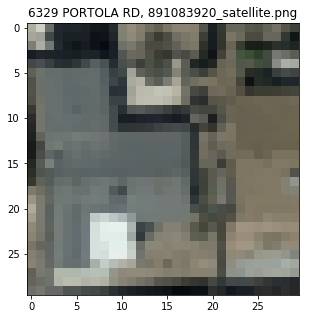

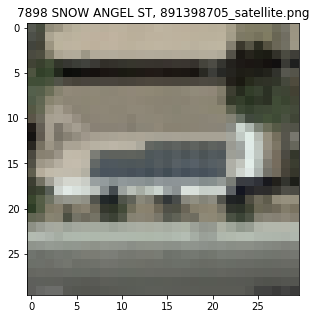

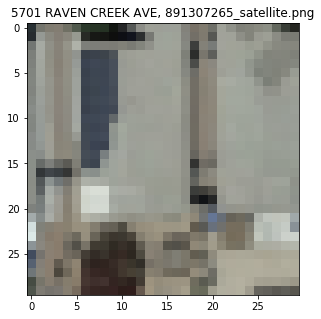

93 Pool Examples
93 No Pool Examples


In [2]:
force_same = True

# Start by counting the number of photos in each class
pool_count = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/with pool'):
    for f in filenames:
        pool_count += 1

no_pool_count = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/without pool'):
    for f in filenames:
        no_pool_count += 1
        # for now we'll ensure the same number of pool/no pool examples to avoid biasing the model
        if (no_pool_count == pool_count) and force_same:
            break

total_count = pool_count + no_pool_count

# desired shape of the input images
shape = (30,30,3)

# numpy arrays for storing data and labels (first dimension indexes over samples)
X = np.zeros((total_count,)+shape)
y = np.zeros((total_count,))
# because of the order we are loading them, the first ones are all pool examples
y[:pool_count] = 1

index = 0
for (dirpath, dirnames, filenames) in os.walk('../data/pool/with pool'):
    for f in filenames:
        # load the image as numpy array
        im = io.imread('../data/pool/with pool/' + f)
        # resize image to desired shape
        im_resize = imresize(im,shape)
        # store in data matrix
        X[index,:,:,:] = im_resize
        index += 1
        if index < 4:
            plt.figure(figsize=(5,5))
            plt.imshow(im_resize)
            plt.title(f)
            plt.show()

for (dirpath, dirnames, filenames) in os.walk('../data/pool/without pool'):
    for f in filenames:
        im = io.imread('../data/pool/without pool/' + f)
        im_resize = imresize(im,shape)
        X[index,:,:,:] = im_resize
        index += 1
        if index - pool_count < 4:
            plt.figure(figsize=(5,5))
            plt.imshow(im_resize)
            plt.title(f)
            plt.show()
        if (index == total_count) and force_same:
            break
        
print("%i Pool Examples"%pool_count)
print("%i No Pool Examples"%no_pool_count)

Now that the complete data and labels are loaded we can split them into testing and training sets, store important values, and prepare the data for use by Keras.

In [3]:
# train on 2/3 and test on 1/3 of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# store the details
num_train, height, width, depth = X_train.shape
num_test = X_test.shape[0]

# ensure input data is correct type
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

#normalize input data
X_train /= np.max(X_train)
X_test /= np.max(X_test)

Next we specify all the parameters used to create the network. This portion needed a significant amount of parameter tuning. Most of this tuning was done by hand simply because there are too many options that automating a sweep over the whole space would have taken a long time to run. From what I've read, the relatively small amount of data creates a concern of overfitting the network. The overarching structure of the network seemed to be pretty widely used: 

$$
\texttt{input ->} \left( \texttt{conv -> conv -> pool -> drop} \right)\times \texttt{2 -> hidden -> drop -> output}
$$

With that in mind, the parameters that I considered changing are:

- **batch size**: number of samples used to compute the gradient in iteration
- **num epochs**: number of times to complete entire dataset (thus $total\_iterations = num\_epochs \times \frac{num\_samples}{batch\_size}$)
- **kernel size**: size of the window that is convolved with the input
- **pool size**: size of max pooling windows at each pooling layer
- **convolutional layer depth**: number of kernels in the layer (essentially the number of filters learned) (one depth for each of the 2 sets of conv layers)
- **drop probability**: number of weights to randomly zero out in the dropout layers
- **hidden size**: number of neurons in the fully connected classification layer
- **regularization parameter**: weight for regularization on the parameters (one for convolutional layers and one for hidden layer)
- **learning rate**: step size for weight updating algorithm, affects how quickly the fit converges

In terms of batch size, kernel size, pool size, and drop probability, I essentially left these as is from what I saw online. For the rest of the parameters I started with a very small network (changing conv layer depth and hidden size) to ensure that it was not complex enough to capture the distinguishing features of the images. This behavior can be observed by the accuracy plot in the next code cell when neither the blue and orange lines show a clear upward trend, meaning that the accuracy on the training and validation sets is not improving. Then I upped the layer sizes until the network was complex enough to represent the training data. Once the network is complex enough to classify the training data (training accuracy -> 1), I check to see if the accuracy on the validation set is also steadily increasing, or if the network is overfitting the training data. If the network is overfitting, then we can reduce the capacity of the network by imposing regularization on the weights. Basically, we check for the following behaviors:

**1)** *Both training and validation accuracy are poor* - The network is not sophisticated enough. Increase: layer sizes, resolution, or kernel size. Decrease: Pool size, regularization amount, or learning rate.

**2)** *Training accuracy is good, validation accuracy is poor* - The network is overfitting the training data. Fixes are opposite of **1)**.

**3)** *Training accuracy is good, validation accuracy is good, but not great* - The network is sophisticated enough to represent the training data, but does not generalize well. Can increase the layer sizes and then add regularization as necessary to prevent overfitting.

In [4]:
batch_size = 10 # in each iteration, we consider 10 training examples at once
num_epochs = 200 # we iterate 200 times over the entire training set
learning_rate = 0.001 # learning rate for optimization algorithm
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 8 # we will initially have 8 kernels per conv. layer...
conv_depth_2 = 16 # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 32 # the FC layer will have 32 neurons
conv_reg = 0.002 # amount of regularization to perform in convolutional layers (l2)
hidden_reg = 0.02 # amount of regularization to perform in the hidden layer (l2)

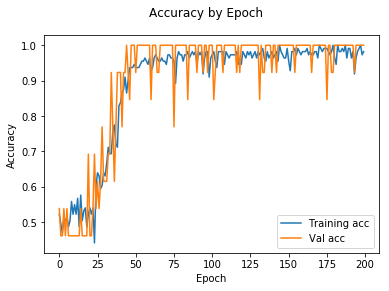

In [5]:
inp = Input(shape=(height, width, depth)) # depth goes last in TensorFlow back-end (first in Theano)
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size),
                       kernel_regularizer=regularizers.l2(conv_reg), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden1 = Dense(hidden_size, activation='relu',kernel_regularizer=regularizers.l2(hidden_reg))(flat)
drop_3 = Dropout(drop_prob_2)(hidden1)
out = Dense(1, activation='sigmoid')(drop_3)

model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

rms_prop = RMSprop(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=rms_prop,
              metrics=['accuracy'])

fit_results = model.fit(X_train, y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=0, validation_split=0.1,class_weight={0:1,1:1}) # ...holding out 10% of the data for validation

# Plot the loss over each epoch
plt.plot(fit_results.history['acc'], label='Training acc')
plt.plot(fit_results.history['val_acc'], label='Val acc')
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.suptitle("Accuracy by Epoch")
plt.show()

In [6]:
y_hat = model.predict(X_test)
labels = (y_hat > 0.5)
y_hat = [label[0] for label in labels.astype(int)]

print("Test Accuracy: %f"%(float(sum(y_hat == y_test))/len(y_hat)))
print("Chance Accuracy: %f"%(1-float(sum(y_test))/len(y_hat)))
print("Solar Examples:%i"%sum(y_test == 1))
print("Misses:%i"%sum(y_hat - y_test == -1))
print("No Solar Examples:%i"%sum(y_test == 0))
print("False Alarms:%i"%sum(y_hat - y_test == 1))

Test Accuracy: 0.887097
Chance Accuracy: 0.467742
Solar Examples:33
Misses:7
No Solar Examples:29
False Alarms:0


As we can see, the performance of the network is already quite good. Out of the 62 hold out testing samples, only one is missclassified!

## Data Augmentation

While it does not appear to be an issue here (because the problem is very simple), a common issue with using neural networks is insufficient data. Here, we are only using about 200 samples total for training, validation and hold-out testing, which is considered a tiny amount of data in any modern application. To try and squeeze a tiny bit more performance out of the network, we can use a data generation package to augment our training samples with the hopes of allowing our network to generalize even more. Below we specify the parameters that decide how the data can be randomly augmented. While all the parameters are shown below, we will only allow for images to be rotated, zoomed in, and flipped horizontally and/or vertically.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=10.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.,
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None)

Below we combine the original training data and labels with 200 augmented samples. Note that the labels for the augmented samples are just the same label that applied to the sample before it is randomly modified.

In [8]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

augmented_data = np.zeros((0,) + shape)
augmented_labels = np.asarray([])

i = 0
for batch_data,batch_labels in datagen.flow(X_train, y_train, batch_size=10):
    augmented_data = np.vstack((augmented_data,batch_data))
    augmented_labels = np.append(augmented_labels,batch_labels)
    if i == 20:
        break
    i += 1
    
    
X_aug_train = np.vstack((X_train,augmented_data))
y_aug_train = np.append(y_train,augmented_labels)

Next we repeat the same training process on the augmented training set.

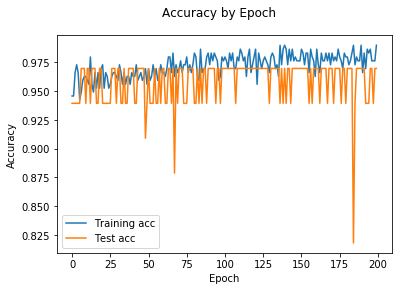

In [9]:
fit_aug_results = model.fit(X_aug_train, y_aug_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=0, validation_split=0.1) # ...holding out 10% of the data for validation

model.evaluate(X_test, y_test, verbose=0)  # Evaluate the trained model on the test set!

# Plot the loss over each epoch
plt.plot(fit_aug_results.history['acc'], label='Training acc')
plt.plot(fit_aug_results.history['val_acc'], label='Test acc')
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.suptitle("Accuracy by Epoch")
plt.show()

We see that the training and testing accuracy are not quite as good as they were before. While I'm not sure why this is, one theory is that some of the augmented images end up in the wrong class. For example, if a pool is on the edge of the photo and the photo gets zoomed in, then the result may not have a pool but still gets labeled as such. Or perhaps the method for filling in the blank spots in a rotated image causes pool-like artifacts to appear where there are no pools. Either way, let's see how the performance compares on the hold-out test set:

Test Accuracy: 0.935484
Chance Accuracy: 0.467742
Solar Examples:33
Misses:3
No Solar Examples:29
False Alarms:1
1.000000 - Success
1.000000 - Success
1.000000 - Success
0.018243 - Success
0.018243 - Success
0.999871 - Success
0.018243 - Success
1.000000 - Success
0.018243 - Success
0.292414 - Failure


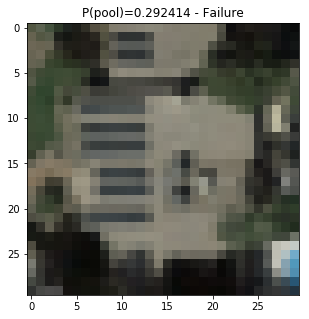

0.018243 - Success
1.000000 - Success
1.000000 - Success
1.000000 - Success
0.018243 - Success
1.000000 - Success
0.018243 - Success
1.000000 - Success
0.026871 - Success
0.998037 - Success
0.978987 - Success
0.018243 - Success
1.000000 - Success
0.163823 - Failure


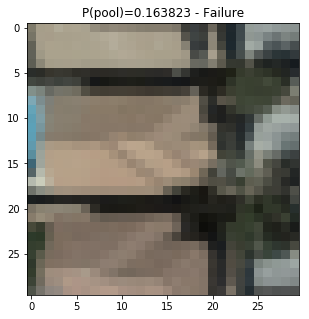

0.999841 - Success
1.000000 - Success
1.000000 - Success
0.018243 - Success
0.018243 - Success
0.019685 - Success
1.000000 - Success
0.018243 - Success
1.000000 - Success
0.018243 - Success
1.000000 - Success
1.000000 - Success
0.999946 - Success
0.018243 - Success
0.999829 - Success
1.000000 - Success
1.000000 - Success
0.999520 - Success
0.018243 - Success
1.000000 - Success
0.018307 - Success
0.018243 - Success
0.018243 - Success
1.000000 - Success
0.018243 - Success
0.018243 - Success
0.069615 - Success
1.000000 - Success
0.999999 - Success
1.000000 - Success
0.018243 - Success
0.527321 - Failure


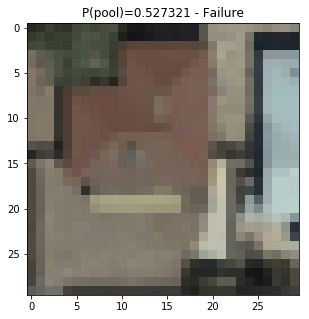

0.052036 - Success
0.254233 - Failure


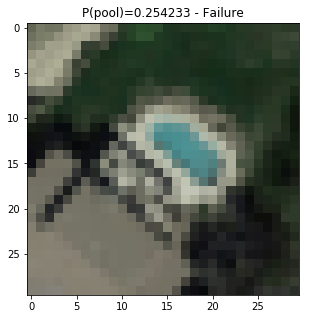

0.018243 - Success
0.021571 - Success
0.020578 - Success
0.018846 - Success


In [11]:
y_hat = model.predict(X_test)
labels = (y_hat > 0.5)
y_hat = [label[0] for label in labels.astype(int)]

print("Test Accuracy: %f"%(float(sum(y_hat == y_test))/len(y_hat)))
print("Chance Accuracy: %f"%(1-float(sum(y_test))/len(y_hat)))
print("Solar Examples:%i"%sum(y_test == 1))
print("Misses:%i"%sum(y_hat - y_test == -1))
print("No Solar Examples:%i"%sum(y_test == 0))
print("False Alarms:%i"%sum(y_hat - y_test == 1))

for i in range(X_test.shape[0]):
    x_i = X_test[i,:,:,:]
    y_i = model.predict(np.expand_dims(x_i,axis=0))[0]
    label_i = int(y_i>0.5)
    if label_i == y_test[i]:
        outcome = 'Success'
    else:
        outcome = 'Failure'
    print('%f - %s'%(y_i,outcome))
    if np.abs(y_i - label_i) > 0.1:
        plt.figure(figsize=(5,5))
        plt.imshow(x_i)
        plt.title('P(pool)=%f - %s'%(y_i,outcome))
        plt.show()

We see that not only are there no misclassifications, but the network is very sure of itself in basically every example. The images that are shown are those where the model assigns a probability of pool that is greater than 0.1 away from the true label. We see that in two cases, the model is not completely sure that an image doesn't contain a pool because there are bits of roof that are a little bluish. Other than these examples, there is very little uncertainty in the estimate.

## Visualizing the Network

In order to better understand the network, let's take a look at the output of two of the convolutional layers. A couple things to note are: 1) The filters in the first convolutional layer are more focused on higher level features: the first one does some smoothing, a few others do edge detection, and a few more are starting to identify blue. 2) The last convolutional layer has begun to focus almost entirely on the presence of blue color. This is the final layer before entering the fully connected section for classification. At this point it is pretty clear how classification is done. 3) Note the difference in maximum value between the pool outputs and the non-pool outputs. Even though it may look like the non-pool outputs are activating in some places, those values are much smaller than the pool activations and therefore do not trigger pool classifications.

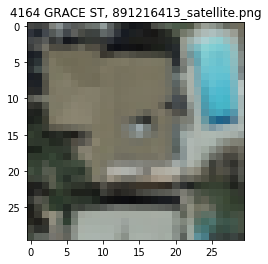

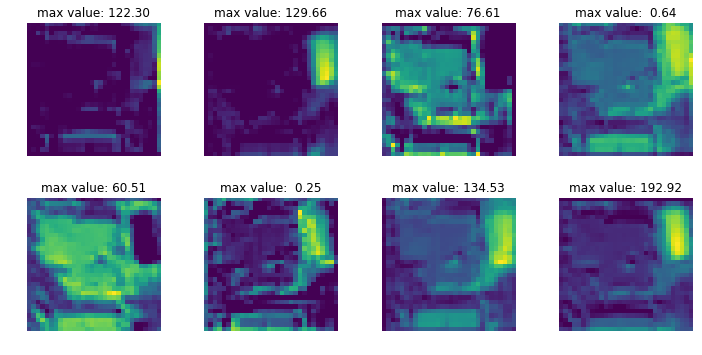

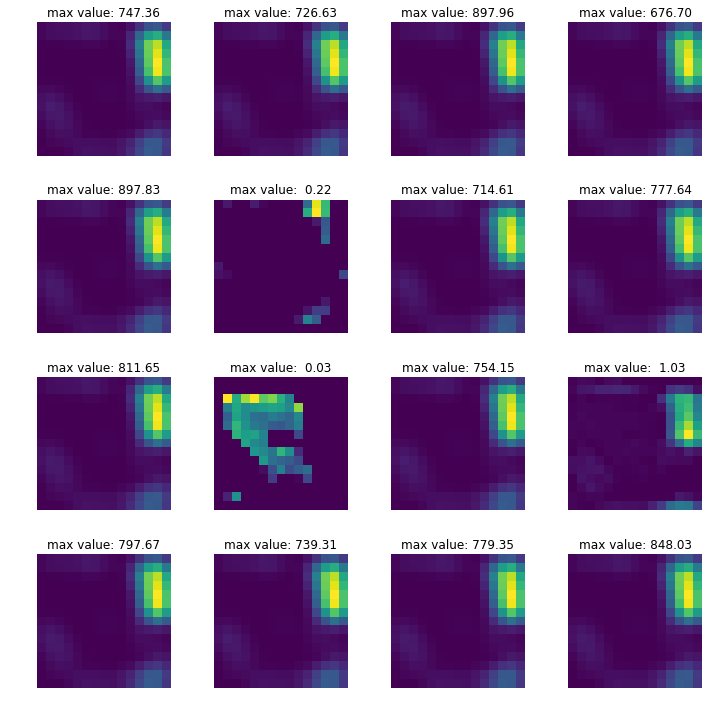

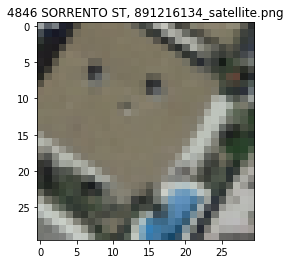

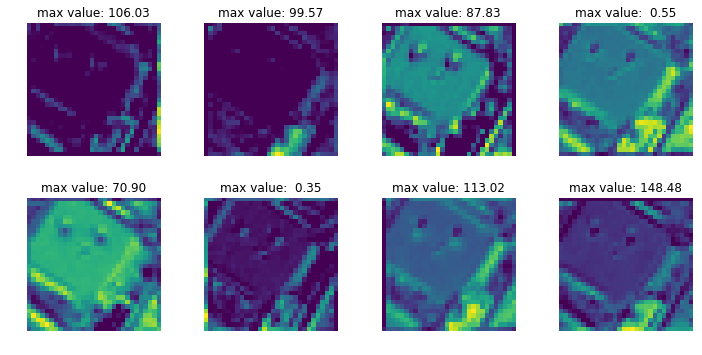

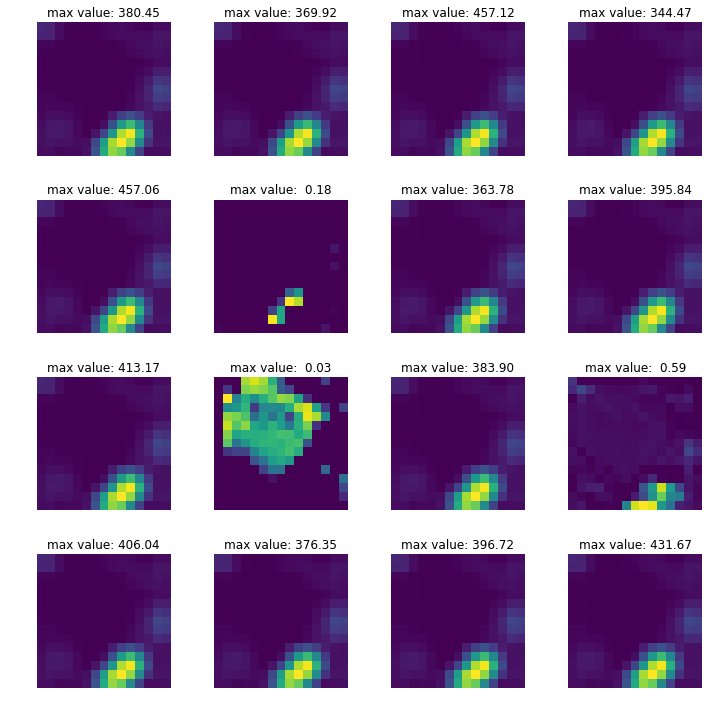

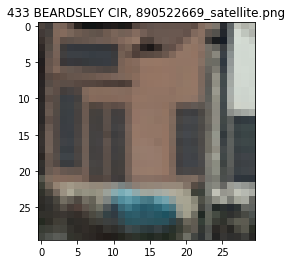

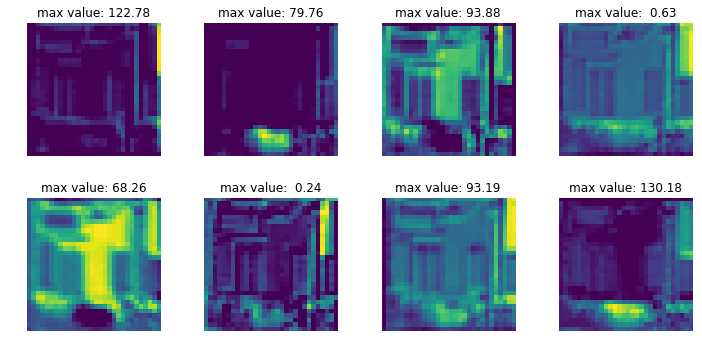

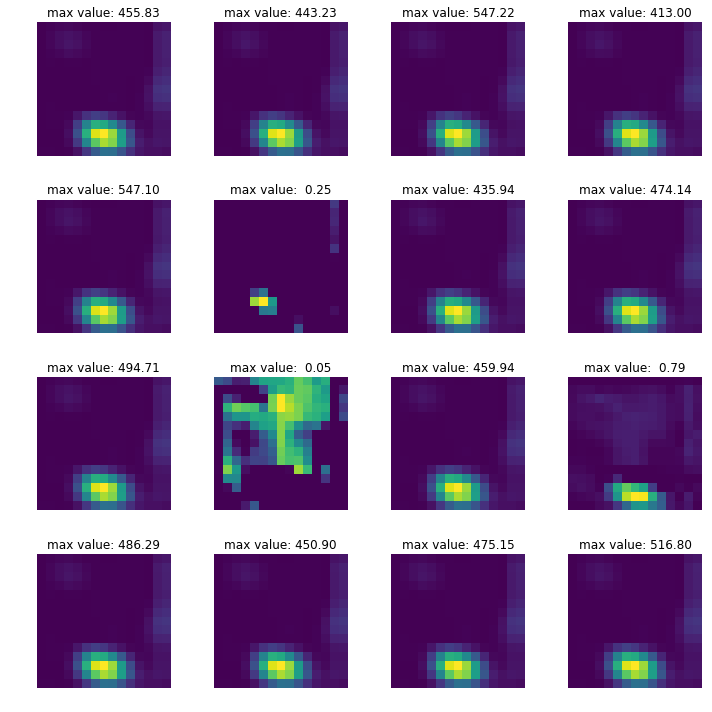

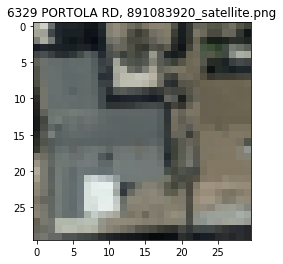

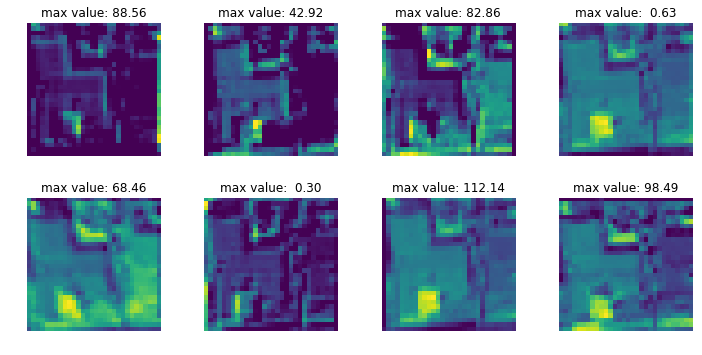

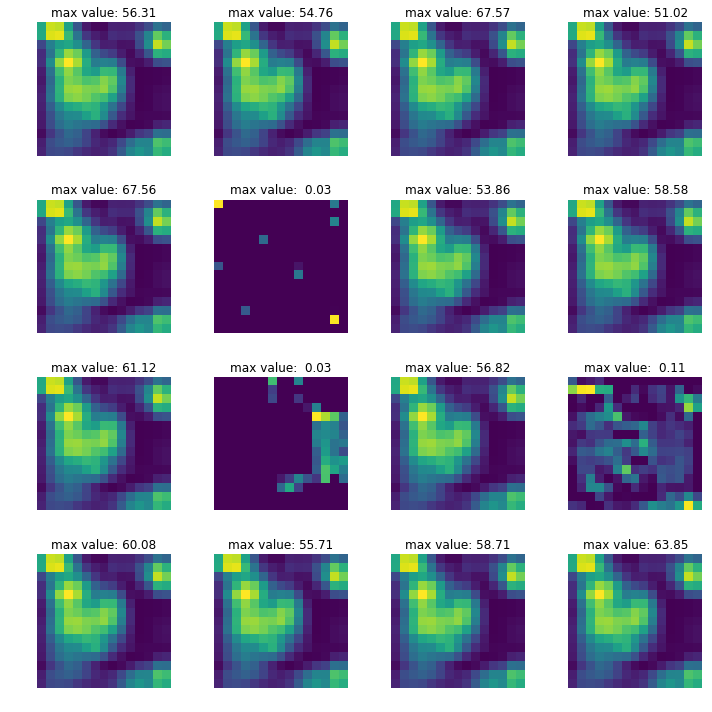

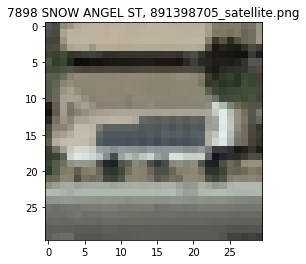

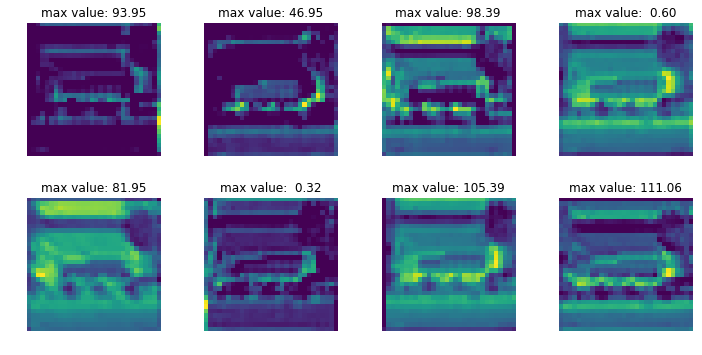

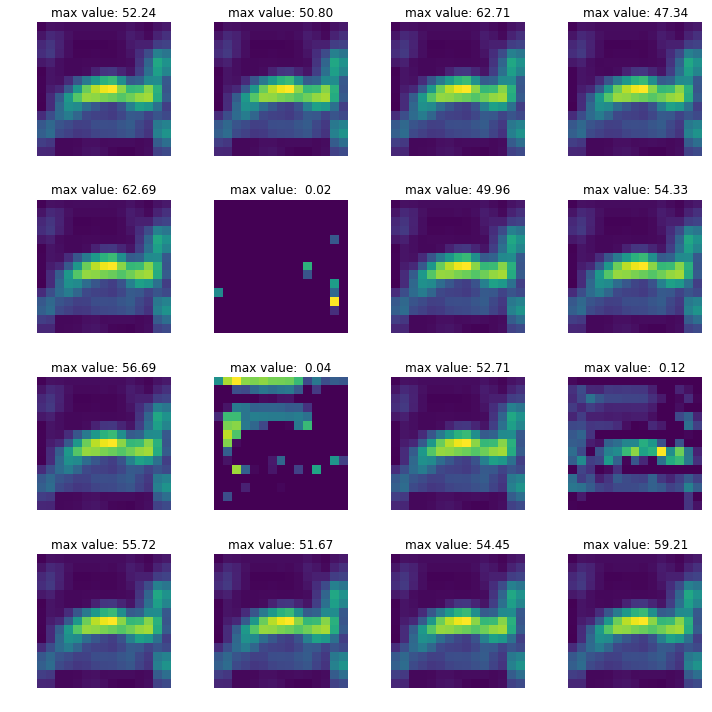

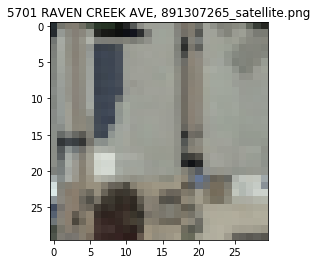

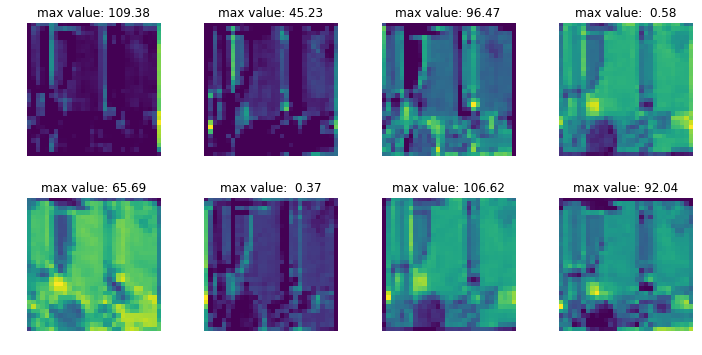

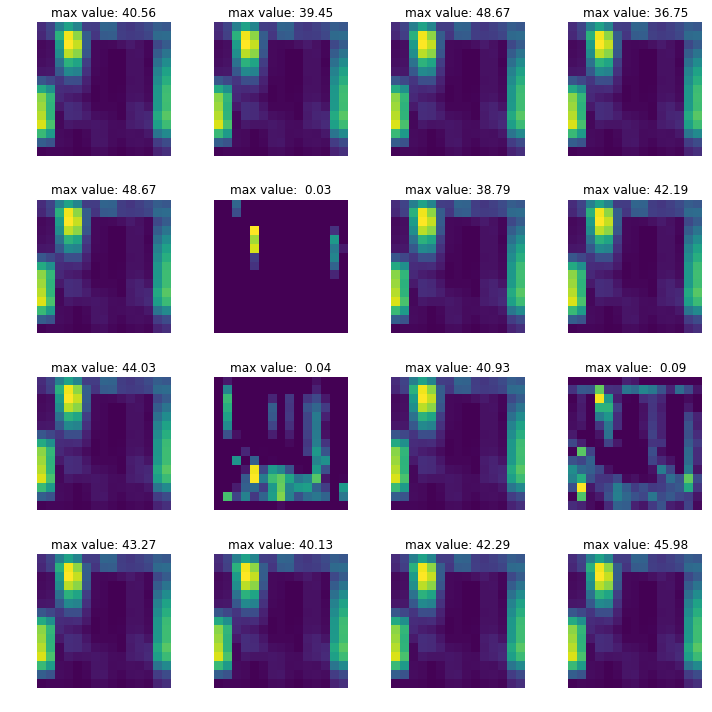

In [12]:
intermediate_layer_model1 = Model(inputs=model.input,
                                 outputs=model.layers[1].output)

intermediate_layer_model2 = Model(inputs=model.input,
                                 outputs=model.layers[5].output)

index = 0
pool_clims = []
for (dirpath, dirnames, filenames) in os.walk('../data/pool/with pool'):
    for f in filenames:
        im = io.imread('../data/pool/with pool/' + f)
        im_resize = imresize(im,shape)
        X[index,:,:,:] = im_resize
        index += 1
        if index < 4:
            
            plt.figure(figsize=(4,4))
            plt.imshow(im_resize)
            plt.title(f)
            
            out1 = intermediate_layer_model1.predict(np.expand_dims(im_resize,axis=0))   
            fig,axarr = plt.subplots(2,4,figsize=(10,5))
            plt.title('layer 1 filter outputs')
            axarr = axarr.reshape(-1)
            for i in range(8):
                filt = axarr[i].imshow(np.squeeze(out1,axis=0)[:,:,i])
                axarr[i].set_title('max value: %5.2f'%(filt.get_clim()[1]))                                   
                axarr[i].axis('off')
            plt.tight_layout()
            plt.savefig('../out1_'+f+'.png')
            plt.show()
            
            out2 = intermediate_layer_model2.predict(np.expand_dims(im_resize,axis=0))
            fig,axarr = plt.subplots(4,4,figsize=(10,10))
            plt.title('layer 6 filter outputs')
            axarr = axarr.reshape(-1)
            for i in range(16):
                filt = axarr[i].imshow(np.squeeze(out2,axis=0)[:,:,i])
                axarr[i].set_title('max value: %5.2f'%(filt.get_clim()[1]))                                   
                axarr[i].axis('off')
            plt.tight_layout()
            plt.savefig('../out2_'+f+'.png')
            plt.show()
            
        else:
            break
index = 0
no_pool_clims = []
for (dirpath, dirnames, filenames) in os.walk('../data/pool/without pool'):
    for f in filenames:
        im = io.imread('../data/pool/without pool/' + f)
        im_resize = imresize(im,shape)
        X[index,:,:,:] = im_resize
        index += 1
        if index < 4:
            plt.figure(figsize=(4,4))
            plt.imshow(im_resize)
            plt.title(f)
            
            out1 = intermediate_layer_model1.predict(np.expand_dims(im_resize,axis=0))   
            fig,axarr = plt.subplots(2,4,figsize=(10,5))
            plt.title('layer 1 filter outputs')
            axarr = axarr.reshape(-1)
            for i in range(8):
                filt = axarr[i].imshow(np.squeeze(out1,axis=0)[:,:,i])
                axarr[i].set_title('max value: %5.2f'%(filt.get_clim()[1]))                                   
                axarr[i].axis('off')
            plt.tight_layout()
            plt.savefig('../out1_'+f+'.png')
            plt.show()
            
            out2 = intermediate_layer_model2.predict(np.expand_dims(im_resize,axis=0))
            fig,axarr = plt.subplots(4,4,figsize=(10,10))
            plt.title('layer 6 filter outputs')
            axarr = axarr.reshape(-1)
            for i in range(16):
                filt = axarr[i].imshow(np.squeeze(out2,axis=0)[:,:,i])
                axarr[i].set_title('max value: %5.2f'%(filt.get_clim()[1]))                                   
                axarr[i].axis('off')
            plt.tight_layout()
            plt.savefig('../out2_'+f+'.png')
            plt.show()
            
        else:
            break
